In [1]:
## . . Import required utilities
import numpy as np
import matplotlib.pyplot as plt
import math as m
from IPython.display import HTML,Image
import scipy.signal

## . . Import all of the libraries required for this Notebook
import matplotlib.image as mpimg
import scipy.ndimage as ndimage

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this Jupyter notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
''')

![title](data/TITLE.png)

### <h1><center>Module 7: Convolution, Correlation and Linear Time-Invariant (LTI) Systems</center></h1>

[Linear time-invariant](https://en.wikipedia.org/wiki/Linear_time-invariant_theory) (LTI) systems are important in many branches of science and engineering (including geophysics!) because they can be completely characterized by the [impulse response](https://en.wikipedia.org/wiki/Impulse_response), which is how a system responds to an impulsive $\delta(t)$ function input. One example of a linear system with an impulse response would be if you gave a small impulsive push to a friend sitting on a swing. What would the response of the system be? Damped oscillation back and forth until eventually coming to rest (where the duration of the period depends on the swing length and the overall amplitude decay depends on the swing's effective damping constant). This time series effectively represents the impulse response of the swing system.

Examples of LTI systems include:

* Spring-mass systems
* Electrical circuits
* 1D Seismic/GPR convolutional modeling 

In fact, [convolution](https://en.wikipedia.org/wiki/Convolution)  and its counterpart [correlation](https://en.wikipedia.org/wiki/Cross-correlation) are two LTI operations that represent two key concepts that you will learn and apply in this course.  Thus, it is worth spending some time on developing your intuition of what this is.  Let us first discuss the geophysical example of convolutional modeling that is one way to think about forward modeling both seismic and GPR data.

#  Convolutional Modeling of Seismic/GPR Data

The Earth's P-wave acoustic impedance ($I_p=\rho V_p $) is commonly represented in terms of 'reflectivity' $\left(\mathrm{i.e.},\,\,r(t)\approx \frac{V_p}{2}\frac{d }{dz}\mathrm{ln}(\rho V_p)\right)$.  One straightforward approach to modeling a 1D (or higher dimension) seismic section is to **convolve** a **seismic wavelet**, $w(t)$, with an **Earth reflectivity sequence**, $r(t)$.  The **output** of this operation, $s(t)$, is approximately the **seismic data trace** you would record between a co-located source and receiver pair.  

Mathematically, this operation is denoted as:  

$$ s(t) = w(t)\ast r(t)+n(t), \tag{1}$$

where $\ast$ represents the convolution operation here between $w(t)$ and $r(t)$, and $n(t)$ is some additive noise.  Figure 1 illustrates the seismic convolutional modeling approach.

<img src="Fig/2.3 Convolutional_model.png" width="650">

**Figure 1. Illustration of the convolutional seismic modeling as a linear time-invariant (LTI) system. The leftmost figure represents a 1D geological profile, while the second panel shows the locations of the discontinuities (i.e., the reflector locations) where the magnitude of the discontinuity is proporational to the impedance contrast.  The third and fourth panels show the convolution of the reflectivity sequence with seismic wavelets of the North American and European conventions, respectively.**

# Two Key Properties of LTI systems

As per the name, a LTI system (here defined by $H[\cdot]$) has two key necessary ingredients:

* [Linearity](https://en.wikipedia.org/wiki/Linear_system): if $[x_1(t),y_1(t)]$ and $[x_2(t),y_2(t)]$ are two input-output pairs (i.e., $y_1(t) = H[x_1(t)]$ and $y_2(t) = H[x_2(t)]$ for some LTI operator $H$), then:

$$ax_1(t)+bx_2(t) \rightarrow ay_1(t)+by_2(t). \tag{2} $$

This principle simply states that you may superimpose two different input signals and the resulting output signal will be the same superposition as if you treated them separately and then stacked the outputs. In the convolutional modeling example above, this would mean that you could: (1) convolve each component of the reflection sequence with the wavelet individually and then stack the result; or (2) convolve the wavelet with the entire reflectivity sequence all at once. Following either scenario will generate the same result.

* [Time-invariance](https://en.wikipedia.org/wiki/Time-invariant_system): If $x(t)\rightarrow y(t)$ then

$$ x(t-t_0) \rightarrow y(t-t_0). \tag{3}$$

This implies that delaying or advancing the operation by a constant $t_0$ produces no affect on the resulting system. (If you were to push your friend on the swing today or tomorrow in an equal manner, would you expect there to be any difference in the resulting motion?)  In the seismic convolutional modeling example above, this means that if you shifted the input reflectivity sequence $r(t)$ to $r(t-t_0)$, you would expect the output seismic trace to be similarly shifted from $y(t)$ to $y(t-t_0)$.

# Convolution (Integral)

One of the most important aspects of an LTI system is that the input-output relationship is characterized by a [convolution](https://en.wikipedia.org/wiki/Convolution) operation alluded to - but not explicitly defined - above.  The convolution integral is written in the following way:

$$ y(t) = x(t) \ast h(t) = \int_{-\infty}^{\infty} x(\tau)\,h(t-\tau)\, \mathrm{d}\tau, \tag{4} $$

where $x(t), y(t)$ and $h(t)$ are the input, output and the response of the LTI system. In equation 4 we see that a dummy integration variable $\tau$ has been introduced.  You'll also notice that one function, $h(t-\tau)$, is **time reversed** relative to the other variable. 

Here is a short pseudo-code to think about the mathematical operation in equation 4:

    For each $t$ in the output space:
        For each $\tau$ in the input space:
            Multiply $x(\tau)$ with time-reversed $h(t-\tau)$
            Accumulate result into output $y(t)$
            
Let's now look a couple of examples.

## Evaluating the convolution integral as a movie

It is an instructive exercise to plot $x(t)$ and a time reversed $h(t)$ on two different pieces of paper.  Initially line the up with no shift applied (i.e., $\tau=0$).  Mentally multiply two functions together and sum the result (i.e., the total area under the curve) to get your output $y(0)$. You can then shift one paper by a $\tau$ units and repeat this exercise. Eventually if you do this for all different values of $\tau$, you can build up the convolution result $y(t)$.

Let's look at a few movie examples that illustrate this procedure.  First, let's examine the **autoconvolution** of the boxcar with itself (i.e., where $f(\tau)=g(\tau)=\Pi_1(\tau))$.  Note that the movie frames are the equivalent of different values of $t$ in equation 4.

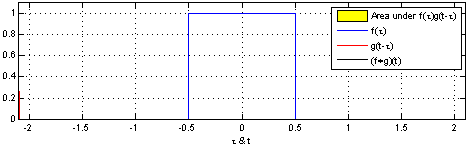

In [2]:
Image(filename="Fig/Convolution_of_box_signal_with_itself2.gif.png")

**Figure 2. Illustration of (auto)convolution. The blue curve is the stationary boxcar $f(\tau)$ while red curve, $g(t-\tau)$, is the time-reversed signal.  For each shift in the convolution (corresponding to the variable $t$), one must multiply the blue and red curves together to get the yellow area, which represents the convolution value at that time shift value $t$. Where the blue and red signals perfectly overlap is when $t=0$; when the red boxcar signal is to the left or right of the blue boxcar, this represents negative and positive values of $t$.  The overall value of $(f\ast g)(t) = f(t)\ast g(t)$ is shown by the black line shaped as a triangle. Note that the value of the yellow area at any particular time shift is the convolution result $(f\ast g)(t) = f(t)\ast g(t)$.**

Let's now look at another example of a box car $g(t)$ convolved with a spikey decaying exponential function $f(t)$. Again, the frames of the movie are playing over the variable $t$.

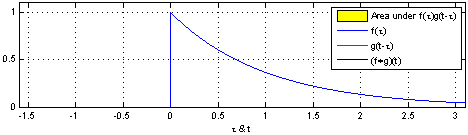

In [3]:
Image(filename="Fig/Convolution_of_spiky_function_with_box2.gif.png")

**Figure 3. As in Figure 2 but with a one-sided function.**

## Example 1a - Spike-Gaussian Convolution 

Let's look at the (numerical) convolution of a single input delta function spike $f(t)$ and a supposed Gaussian impulse response of the system $g(t)$ that generates our output $f(t)\ast g(t)$.  We'll repeat this example four times where we apply a different delay to the input spike.  

In [8]:
def plotfuncs(t,x,h,n,title):
    plt.subplot(4,2,n)
    plt.plot(t,x,'r',t,h,'b',t,h[::-1],'g')
    plt.xlabel('Samples (time)')
    plt.ylabel('Amplitude')
    plt.title(title+r' Signals $f(\tau)$, $g(\tau)$ and $g(0-\tau)$')
    plt.legend([r'$f(\tau)$',r'$g(\tau)$',r'$g(0-\tau)$'])
    plt.axis([0,200,-1.1,1.1])

def plotconvo(t,y,n,title):
    plt.subplot(4,2,n)
    plt.plot(t,y,'k')
    plt.xlabel('Samples (time)')
    plt.ylabel('Amplitude')
    plt.title(title+r' Convolution of Signals $f(\tau)$ and $g(t-\tau)$')
    plt.axis([-100,100,-2.1,2.1])

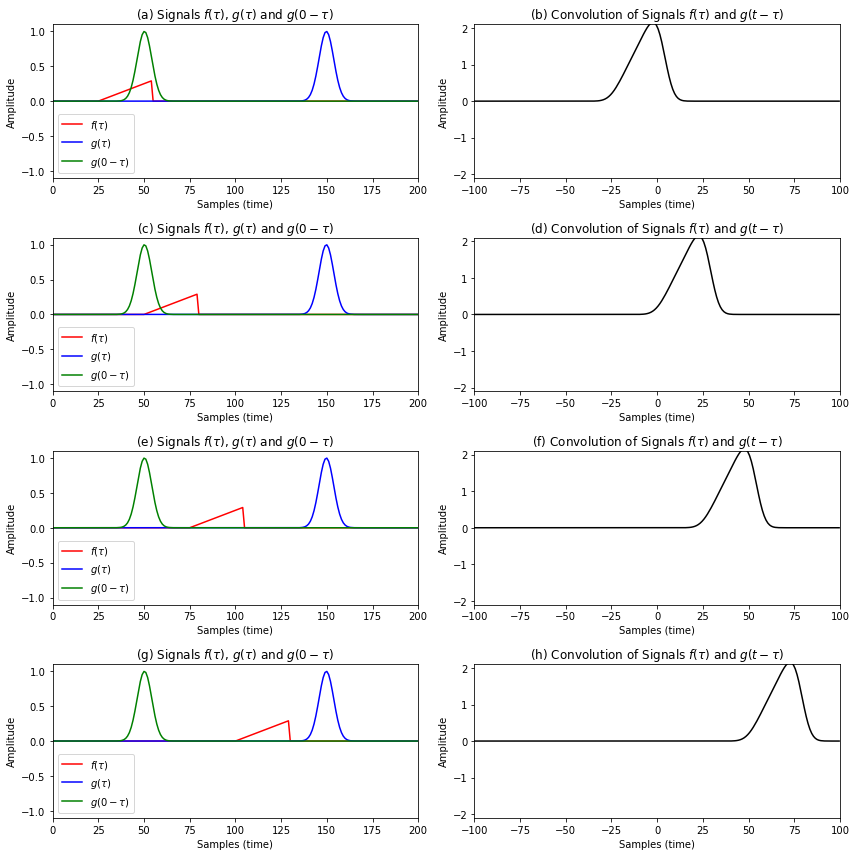

In [11]:
# . . Simple convolutional model demonstration
nt=201
t = np.arange(0,1,1/nt)
xline   = np.arange(0,nt,1)
tauline = np.arange(-nt/2,nt/2,1)

# . . Input signals (shifted in time with respect to each other)
f0 = np.zeros(nt); f0[25]=1
f1 = np.zeros(nt); f1[50]=1
f2 = np.zeros(nt); f2[75]=1
f3 = np.zeros(nt); f3[100]=1
f0[ 25: 55]=np.arange(0,30,1)*0.01
f1[ 50: 80]=np.arange(0,30,1)*0.01
f2[ 75:105]=np.arange(0,30,1)*0.01
f3[100:130]=np.arange(0,30,1)*0.01

# . . Impulse response (stationary for the four examples)
g = np.zeros(nt)
g = np.exp(-(t-0.745)**2/(2*0.02**2))

# . . Plot
plt.figure(figsize=(12, 12))
plotfuncs(xline,f0,g,1,'(a)')
plotconvo(tauline,np.convolve(f0,g,mode='same'),2,'(b)')
plotfuncs(xline,f1,g,3,'(c)')
plotconvo(tauline,np.convolve(f1,g,mode='same'),4,'(d)')
plotfuncs(xline,f2,g,5,'(e)')
plotconvo(tauline,np.convolve(f2,g,mode='same'),6,'(f)')
plotfuncs(xline,f3,g,7,'(g)')
plotconvo(tauline,np.convolve(f3,g,mode='same'),8,'(h)')

plt.tight_layout() 
plt.show()

**Figure 4. Examples of convolving a spike with a Gaussian function.  The left panels show the spike function $f(\tau)$ in red along with the Gaussian function in blue and its time-reversed version in green.  The right panels show the result of convolving the two functions. Note that if the red curve is left of the green curve this results in a negative values of the convolution. The reverse is true if the red curve is to the right of the green curve.**

Let's now look at the convolution of a Gaussian with a sequence of pulses that are spread out like an earth reflectivity model described above:

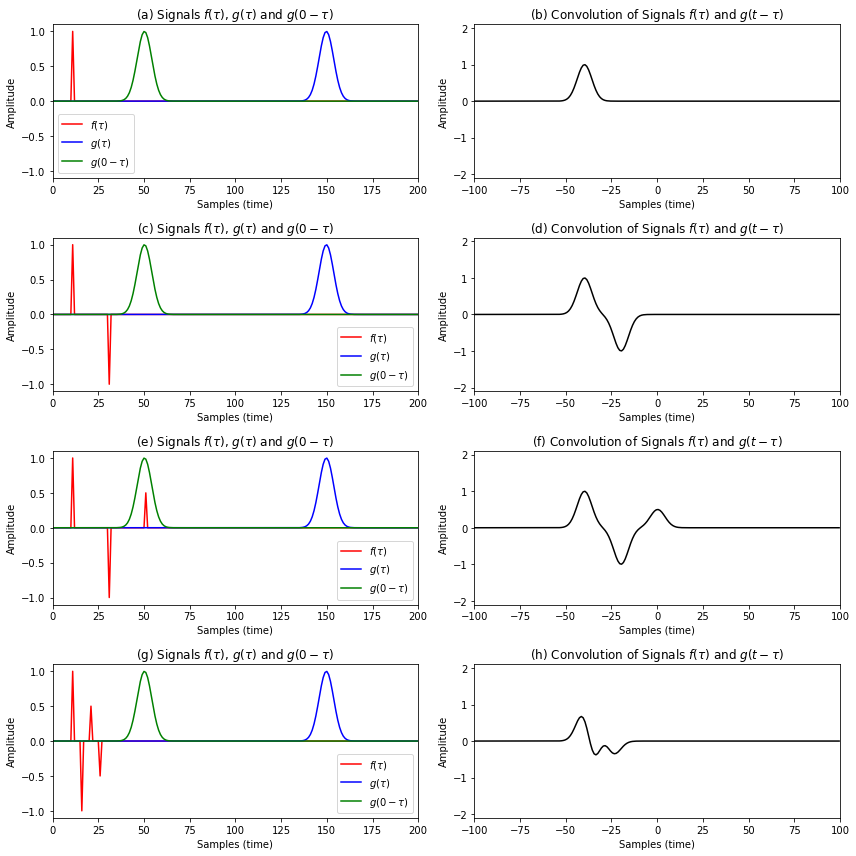

In [10]:
# . . Add more spikes to each
f0 = np.zeros(nt); f0[11]=1;
f1 = np.zeros(nt); f1[11]=1; f1[31]=-1; 
f2 = np.zeros(nt); f2[11]=1; f2[31]=-1; f2[51]=0.5; 
f3 = np.zeros(nt); f3[11]=1; f3[31]=-1; f3[51]=0.5; f3[71]=-0.5; 
f3 = np.zeros(nt); f3[11]=1; f3[16]=-1; f3[21]=0.5; f3[26]=-0.5; 

# . . Plot
plt.figure(figsize=(12, 12))
plotfuncs(xline,f0,g,1,'(a)')
plotconvo(tauline,np.convolve(f0,g,mode='same'),2,'(b)')
plotfuncs(xline,f1,g,3,'(c)')
plotconvo(tauline,np.convolve(f1,g,mode='same'),4,'(d)')
plotfuncs(xline,f2,g,5,'(e)')
plotconvo(tauline,np.convolve(f2,g,mode='same'),6,'(f)')
plotfuncs(xline,f3,g,7,'(g)')
plotconvo(tauline,np.convolve(f3,g,mode='same'),8,'(h)')

plt.tight_layout() 
plt.show()

**Figure 5. Similar to Figure 4, but now where I have introduced a number of spikes with different spacings. Note that the convolutions in (b), (d) and (f) show one, two, and three spikes as expected from the number of red spikes in (a), (c) and (e), respectively. However, the convolution in (h) only shows three "bumps" where one should expect four given the number of spikes. This is because the convolved Gaussian functions are all interferring with each other - both constructively and destructively.**

# Convolution in the Fourier Domain

An important property is that **convolution** in the time domain corresponds to **multiplication** in the Fourier transform domain:

$$y(t) = x(t) \ast h(t) \Leftrightarrow \widehat{X}(\omega)\widehat{H}(\omega) \tag{5}$$

**Proof of the Convolution Theorem**: 

<div class="alert alert-success">
The Fourier transform of $y(t)=x(t)\ast h(t)$ is:

$$ 
\begin{eqnarray}
\widehat{Y}(\omega) &=& \mathcal{F} \left[ x(t)\ast h(t) \right] \\
\, &=& \mathcal{F} \left[ \int_{-\infty}^{\infty} x(\tau)\,h(t-\tau) \,\mathrm{d}\tau \right] \\
\, &=& \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} x(\tau)\,h(t-\tau)\, \mathrm{e}^{-i\omega t} \,\mathrm{d}\tau \, \mathrm{d}t\\
\end{eqnarray}\tag{6}
$$

Let's now assert that $t=u+\tau$ where $u$ is the new integration variable and $\tau$ is a constant shift.  Thus, we may write $\mathrm{d}t = \mathrm{d}u$.  Inserting this into the equation above yields:

$$
\begin{eqnarray}
\widehat{Y}(\omega) &=&  \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} x(\tau)\,h(u)\, \,\mathrm{e}^{-i\omega (u+\tau)}\,\mathrm{d}\tau \,\mathrm{d}u\\
\, &=&  \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} x(\tau)\,h(u)\, \mathrm{e}^{-i\omega \tau}\,\mathrm{e}^{-i\omega u}\,\mathrm{d}\tau \,\mathrm{d}u\\
\,&=& \left[\int_{-\infty}^{\infty} x(\tau)\,\mathrm{e}^{-i\omega \tau}\,\mathrm{d}\tau\right]
\left[
\int_{-\infty}^{\infty} h(u)\,\mathrm{e}^{-i\omega u}\,\mathrm{d}u
\right]\\
\,&=& \widehat{X}(\omega)\,\widehat{H}(\omega)
\end{eqnarray}\tag{7}
$$
</div> 

Thus, the output signal of a convolution in the frequency domain is equal to the product of the Fourier Transforms of input functions.  This is one of the most important properties of convolution.

## Example 2 - Convolution of Two Boxcars

This example looks at the (auto)convolution of twobox car functions of equal width.  You might recognize the result ... a triangle function!  Recall from an earlier example that

$$ \Pi_T(t) \Longleftrightarrow  2 T \, \mathrm{sinc}\left(T\omega\right) \tag{8} $$

Therefore, by the convolution theorem:

$$\Pi_T(t) \ast \Pi_T(t) \Longleftrightarrow 4 T^2 \, \mathrm{sinc}^2\left(T\omega\right)\tag{9} $$ 

You'll also recall that a $\mathrm{sinc}^2$ function is the Fourier Transform of the triangle function. Therefore, you probably wouldn't be surprised to hear that the autoconvolution of a boxcar function is the triangle function! This is illustrated in the example below.

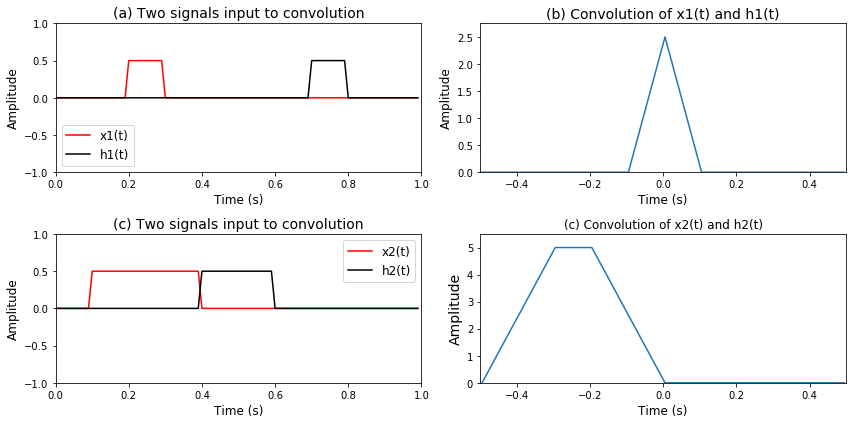

In [6]:
# . . Simple convolutional model demonstration
nt=100
t = np.arange(0,1,1/nt)

# . . Input signal 1
x1 = np.zeros(nt)
x1[20:30]=0.5

# . . Input signal 2
x2 = np.zeros(nt)
x2[10:40]=0.5

# . . Impulse response 1
h1 = np.zeros(nt)
h1[70:80] = 0.5
#h1[50:60] = 0.5

# . . Impulse response 2
h2 = np.zeros(nt)
#h2[60:90] = 0.5
h2[40:60] = 0.5

plt.figure(figsize=(12, 6))

# . . Plot
plt.subplot(2,2,1)
plt.plot(t,x1,'r',t,h1,'k')
plt.xlabel('Time (s)',size=12)
plt.ylabel('Amplitude',size=12)
plt.legend(['x1(t)','h1(t)'],fontsize=12)
plt.title('(a) Two signals input to convolution',size=14)
plt.axis([0,1,-1,1])

plt.subplot(2,2,2)
plt.plot(t-max(t)/2,np.convolve(x1,h1,mode='same'))
plt.title('(b) Convolution of x1(t) and h1(t)',size=14)
plt.xlabel('Time (s)',size=12)
plt.ylabel('Amplitude',size=12)
plt.axis([-0.5,0.5,0,1.1*np.max(np.convolve(x1,h1,mode='same'))])

# . . Plot
plt.subplot(2,2,3)
plt.plot(t,x2,'r',t,h2,'k')
plt.xlabel('Time (s)',size=12)
plt.ylabel('Amplitude',size=12)
plt.legend(['x2(t)','h2(t)'],fontsize=12)
plt.title('(c) Two signals input to convolution',size=14)
plt.axis([0,1,-1,1])

plt.subplot(2,2,4)
plt.plot(t-max(t)/2,np.convolve(x2,h2,mode='same'))
plt.title('(c) Convolution of x2(t) and h2(t)',size=12)
plt.xlabel('Time (s)',size=12)
plt.ylabel('Amplitude',size=14)
plt.axis([-0.5,0.5,0,1.1*np.max(np.convolve(x2,h2,mode='same'))])

plt.tight_layout() 
plt.show()

**Figure 6. (a) Two box car functions where the time-reversed versiron would fall exactly on the red curve. (b) The convolution of the two functions in (a) effectively representing the autoconvolution of the signal.  (c) Two box cars where the red curve is now longer and the black curve is shifted. (d) Convolution of the signals in (c) Note that the result is both broader and has a flat top corresponding to shifts where the black box car is completely within the red box car.**

Thus, to compute the autoconvolution of the boxcar function you can do either one of two things:

1. Compute the convolution of $y(t) = h(t)\ast x(t)$ in the physical domain using a convolution program.
2. Compute the Fourier transforms of $h(t)$ and $x(t)$, multiply the results (i.e., $\widehat{Y}(\omega)=\widehat{X}(\omega)\widehat{H}(\omega)$), and then take the inverse Fourier transform of $\widehat{Y}(\omega)$ to get the desired result $y(t)$.

## Commutativity of the convolution operator

Let's look at proving the following:

$$f(t) \ast g(t) = g(t) \ast f(t) \tag{10}$$

First, let's do it analytically:

**COMMUTATIVITY PROOF**: 
<div class="alert alert-success">
The definition of convolution is given by:
$$f(t)\ast g(t) = \int_{-\infty}^{\infty} f(\tau)g(t-\tau)d\tau \tag{11}$$

However, we may perform a substitution of $t^\prime=t-\tau$, $d\tau=-dt^\prime$ and $\tau=t-t^\prime$ in the above equation.

$$ f(t)\ast g(t) =
- \int_{t+\infty}^{t-\infty} f(t-t^\prime)g(t^\prime)dt^\prime 
\tag{12}$$

However, care must be paid to the integration limits.  First, we note that as $\tau\rightarrow-\infty$ we get $t^\prime=t+\infty=+\infty$.  Similarly, as $\tau\rightarrow +\infty$ we get $t^\prime=t-\infty=-\infty$.  This is why we have had to change the integration limits in equation B. 

The next step is that we reverse the integration limits, which changes the sign of the integral.  Thus, we may write:

$$ f(t)\ast g(t) =
- \int_{+\infty}^{-\infty} f(t-t^\prime)g(t^\prime)dt^\prime 
= \int_{-\infty}^{+\infty}g(t^\prime) f(t-t^\prime)dt^\prime 
=
g(t) \ast f(t)
\tag{13} $$

Thus, the convolution operator is commutative. This should be expected from the Fourier convolution theorem which states: 

$$f(t)\ast g(t) \Leftrightarrow \widehat{F}(\omega)\widehat{G}(\omega)=\widehat{G}(\omega)\widehat{F}(\omega) \Leftrightarrow g(t)\ast f(t) \tag{14} $$
</div>

Let's now show it computationally:

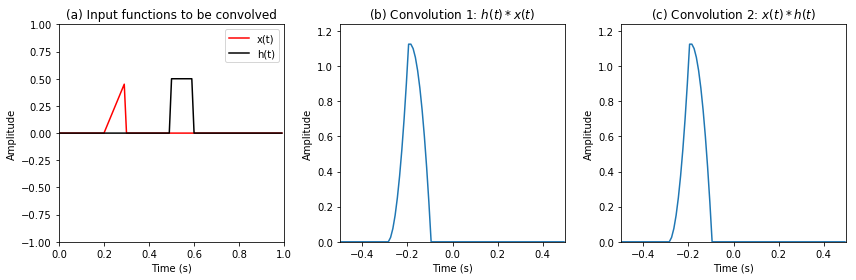

In [7]:
# . . Simple convolutional model demonstration
nt=100
t = np.arange(0,1,1/nt)

# . . Input signal 1
x = np.zeros(nt)
x[20:30]=np.arange(0,10,1)*0.05

# . . Impulse response 1
h = np.zeros(nt)
h[50:60] = 0.5

plt.figure(figsize=(12, 4))

# . . Two functions
plt.subplot(1,3,1)
plt.plot(t,x,'r',t,h,'k')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(['x(t)','h(t)'])
plt.title('(a) Input functions to be convolved')
plt.axis([0,1,-1,1])

# . . Plot convolution x*h
plt.subplot(1,3,2)
plt.plot(t-max(t)/2,np.convolve(x,h,mode='same'))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('(b) Convolution 1: $h(t) * x(t)$')
plt.axis([-0.5,0.5,0,1.1*np.max(np.convolve(h,x,mode='same'))])

# . . Plot convlution h*x
plt.subplot(1,3,3)
plt.plot(t-max(t)/2,np.convolve(h,x,mode='same'))
plt.title('(c) Convolution 2: $x(t) * h(t)$')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.axis([-0.5,0.5,0,1.1*np.max(np.convolve(h,x,mode='same'))])

plt.tight_layout() 
plt.show()

**Figure 7. Illustrating the commutativity of the convolution operator. (a) Two function to be convolved. (b) Convolution $h(t)*x(t)$. (c) Convolution $x(t)\ast h(t)$.**

## Convolution (Computational Efficiency)

From a computational perspective, as the number of samples in a time series gets "large" it becomes more efficient to compute a (fast) Fourier Transform, perform Fourier domain multiplication and then take the inverse Fourier transform.  The [computational complexity](https://en.wikipedia.org/wiki/Computational_complexity_theory) of this operation is $\mathcal{O}\left(n \, log \, n\right)$ rather than $\mathcal{O}\left(n^2\right)$ of performing convolution directly in the time domain.  

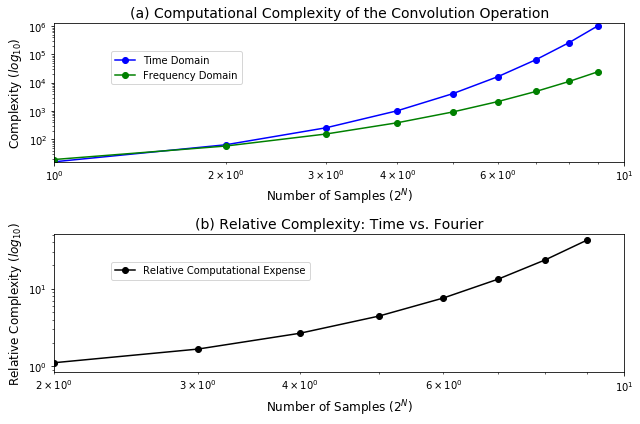

In [20]:
# . . Close all plot windows
plt.close('all')

nmax=10
# . . Set up in powers of 2^n
n=np.arange(1,nmax,1)

# . . Convolution in time domain
timedomain=np.zeros(nmax)
timedomain = (2.**(n+1))**2;

# . . Convolution in the Fourier domain
freqdomain=np.zeros(nmax)
freqdomain = 8.*(2.**(n+1)) * np.log10(2**(n+1))

# . . Compute relative ration
relratio= timedomain/freqdomain 

# . . Let's make a figure
plt.figure(figsize=(9, 6))

plt.subplot(211)
plt.loglog(n,timedomain,'b-o',label='Time Domain')
plt.loglog(n,freqdomain,'g-o',label='Frequency Domain')
plt.xlabel('Number of Samples ($2^N$)',size=12)
plt.ylabel('Complexity ($log_{10}$)',size=12)
plt.legend(bbox_to_anchor=(0.1, 0.8), loc=2, borderaxespad=0.)
plt.title('(a) Computational Complexity of the Convolution Operation',size=14)

plt.axis([1,nmax,0,1.2*max(timedomain)])

plt.subplot(212)
plt.loglog(n,relratio,'k-o',label='Relative Computational Expense')
plt.xlabel('Number of Samples ($2^N$)',size=12)
plt.ylabel('Relative Complexity ($log_{10}$)',size=12)
plt.legend(bbox_to_anchor=(0.1, 0.8), loc=2, borderaxespad=0.)
plt.axis([2,nmax,-1,1.2*max(relratio)])
plt.title('(b) Relative Complexity: Time vs. Fourier',size=14)

plt.tight_layout() 
plt.show()

**Figure 8. (a) Illustration of the computational complexity of time-domain (blue curve) and frequency-domain (green curve) computation of the convolution operation.  (b) The relative cost of the two curves in (a).**


# Other examples of physical convolutional LTI systems

## GPR Acquisition system

Consider that you are recording a geophysical signal (e.g., GPR wave) denoted by $x(t)$.  The instrument (GPR receiving antenna) you are using has a natural response, $h(t)$.  The recorded GPR data you measure, $y(t)$, will be affected by instrument you are using in a convolution process $y(t)=x(t)\ast h(t)$.  Thus, recorded data $y(t)$ will not be the ''true'' response $x(t)$ unless: (1) you 
have a ''perfectly non-distorting'' instrument (i.e., $h(t)=\delta(t)$); or (2) you account for  the instrument's response through a [deconvolution](https://en.wikipedia.org/wiki/Deconvolution) procedure to recover  $x(t)$ (that is, assuming you know $h(t)$):

$$ x(t) = \mathcal{F}^{-1}\left[ \frac{\widehat{Y}(\omega)}{\widehat{H}(\omega)} \right] =  \mathcal{F}^{-1}\left[ \frac{\mathcal{F}[y(t)]} {\mathcal{F}[h(t)]} \right]. \tag{15} $$

**Q: What are the potential problems or challenges with a deconvolutional approach?**

## Human hearing

There is a far-field acoustic source $x(t)$ in your presence.  Your hearing system has two inputs $h_L(t)$ and $h_R(t)$ (i.e., your ears!).  Unfortunately, they are an imperfect sensing instrument and thus what you actually ''hear'' is a convolution product. 

$$ y(t) = \left[ h_L(t)+h_R(t)\right]\ast x(t) \tag{16} $$

Hearing aids with responses $a_L(t)$ and $a_R(t)$ can be introduced to improve your response!!  This leads to a more complicated LTI model:

$$ y(t) = \left[ a_L(t) \ast h_L(t)+a_R(t) \ast h_R(t)\right]\ast x(t) \tag{17} $$

See Figure 9 for an illustration.
<img src="Fig/2.3-EARS.png" width="300">

**Figure 9. Illustration of the ears plus hearing aids as an LTI system. In this scenario an acoustic source produces a signal $x(t)$ that propagates through the air and is detected by you the listener.  Your hearing system has two detectors, your left and right ears $h_L(t)$ and $h_R(t)$.  Your brain thus detects the convolution of your ear's responses and the signal.  Of course if you have hearing aids this is more complicated since your ear response is now the convolution of the previous result with the hearing aid response (which can be different in the left and right ears)!**

# Convolution in Action

## Convolution with a $\delta$-function

Convolution of a function $f(t)$ with a $\delta$-function shifted by $a$ unit gives

$$f(t-a) =  \int_{-\infty}^{\infty} f(t)\,\delta(a-t)\,\mathrm{d}t=  \int_{-\infty}^{\infty} f(t)\,\delta(t-a)\,\mathrm{d}t \tag{18} $$

by virtue of the properties of the $\delta$-function.  We may write this symbolically as

$$ f(t) \ast \delta (t-a) = f(t-a). \tag{19} $$

Applying the convolution theorem to this result [because $\delta(t-a) = \delta (a-t)$ in equation 18 above] since it yields the Fourier shift theorem:

$$ f(t) \Leftrightarrow \widehat{F}(\omega); \quad \delta(t-a) \Leftrightarrow \mathrm{e}^{-i \omega a},  \tag{20}
$$

which yields the following:

$$ f(t-a) = f(t) \ast \delta (t-a) \Leftrightarrow \widehat{F}(\omega)\mathrm{e}^{-i\omega a}. \tag{21} $$

which is the multiplication of the two signals' Fourier spectra! The interpretation of this is that the shifting of a time series by $a$ units leads to the similar Fourier spectrum that has a phase shift of ${\rm e}^{-i\omega a}$ applied to it.

## Convolution with a pair of $\delta$-functions

Based on our previous exploration of the Fourier transform of $\delta$-functions, we can identify the following:


$$ \left[\delta(t-a)+\delta(t+a)\right] \Leftrightarrow 2\,\mathrm{cos}\,(\omega a), \tag{22} $$

with a similar result holding if the delta functions were defined in the Fourier domain.  The convolution of the expression in equation 17 with a function $f(t)$ is given by

$$ \left[\delta(t-a)+\delta(t+a)\right] \ast f(t) \Leftrightarrow 2\,\mathrm{cos}\,(\omega a) \widehat{F}(\omega),\tag{23} $$

which is again the product of the signals' respective Fourier transforms.

## Two Gaussian functions

An interesting example that comes up quite frequently in probability theory (including geophysical inverse problems  when modeling probability density fucntions) is the convolution of two Gaussian functions. Say we have two Gaussian functions of width $a$ and $b$, $f(t)=\mathrm{e}^{-t^2/a^2}$ and $g(t)=\mathrm{e}^{-t^2/b^2}$ respectively.  In the Fourier domain we know that the respective Fourier transforms are given by:

$$\widehat{F}(\omega) = a\sqrt{\pi}\,\mathrm{e}^{-a^2\omega^2/4} \tag{24} $$

and

$$\widehat{G}(\omega) = b\sqrt{\pi}\,\mathrm{e}^{-b^2\omega^2/4}. \tag{25} $$

Thus, according to the Fourier domain convolution theorem, we may write:

$$ 
\begin{eqnarray}
f(t) \ast g(t) &=& \mathcal{F}^{-1}\left[\widehat{F}(\omega)\cdot \widehat{G}(\omega)\right]\tag{26a} \\
\,&=& \mathcal{F}^{-1}\left[
ab\pi \mathrm{e}^{-(a^2+b^2)\omega^2/4}
\right] \tag{26b}\\
\, &=& \frac{a b \pi }{\sqrt{a^2+b^2}}\mathrm{e}^{-t^2/(a^2+b^2)}. \tag{26c}
\end{eqnarray}
$$

Importantly, the convolution of two Gaussians with widths $a$ and $b$ **is also a Gaussian of width $\sqrt{a^2+b^2}$.**  Let's test this out with a numerical example.

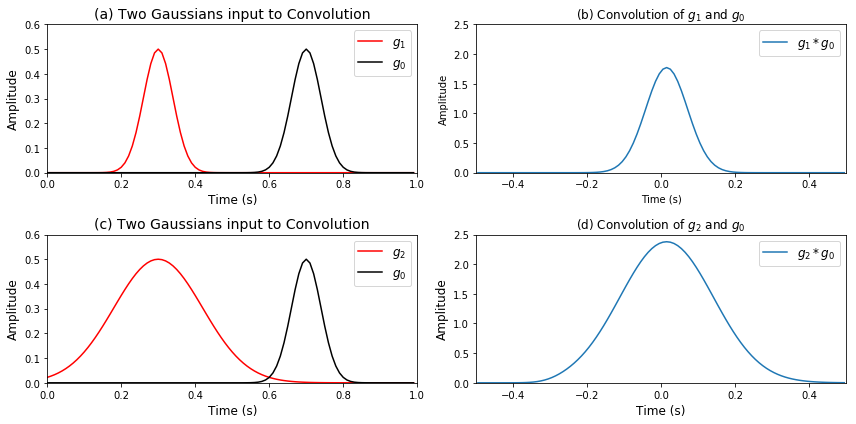

In [9]:
# . . Simple convolutional model demonstration
nt=100
t = np.arange(0,1,1/nt)

# . . Input signal 1
g1 = np.zeros(nt)
g1 = 0.5*np.exp(-(t-0.3)**2/(2*0.04**2))

# . . Input signal 2
g2 = np.zeros(nt)
g2 = 0.5*np.exp(-(t-0.3)**2/(2*0.12**2))

# . . Impulse response
g0 = np.zeros(nt)
g0 = 0.5*np.exp(-(t-0.7)**2/(2*0.04**2))

plt.figure(figsize=(12, 6))

# . . Plot
plt.subplot(2,2,1)
plt.plot(t,g1,'r',t,g0,'k')
plt.xlabel('Time (s)',size=12)
plt.ylabel('Amplitude',size=12)
plt.legend(['$g_1$','$g_0$'],fontsize='12')
plt.title('(a) Two Gaussians input to Convolution',size=14)
plt.axis([0,1,0,0.6])

plt.subplot(2,2,2)
plt.plot(t-max(t)/2,np.convolve(g1,g0,mode='same'))
plt.title('(b) Convolution of $g_1$ and $g_0$')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(['$g_1*g_0$'],fontsize='12')
plt.axis([-0.5,0.5,0,2.5])

# . . Plot
plt.subplot(2,2,3)
plt.plot(t,g2,'r',t,g0,'k')
plt.xlabel('Time (s)',size=12)
plt.ylabel('Amplitude',size=12)
plt.legend(['$g_2$','$g_0$'],fontsize='12')
plt.axis([0,1,0,0.6])
plt.title('(c) Two Gaussians input to Convolution',size=14)

plt.subplot(2,2,4)
plt.plot(t-max(t)/2,np.convolve(g2,g0,mode='same'))
plt.title('(d) Convolution of $g_2$ and $g_0$')
plt.xlabel('Time (s)',size=12)
plt.ylabel('Amplitude',size=12)
plt.legend(['$g_2*g_0$'],fontsize='12')
plt.axis([-0.5,0.5,0,2.5])

plt.tight_layout() 
plt.show()

**Figure 10. Illustrating the convolution of two Gaussian functions.  (a) Two shifted but otherwise identical  Gaussian functions. (b) The convolution of functions in (a). (c) Two shifted an unequal Gaussian Functions. (d) The convolution of functions in (c). Note that convolving Gaussian functions will broaden the resulting Gaussian function.**

One interesting observation is that because the resulting function after the convolution is broader, convolution with a Gaussian filter is a **low-pass filtering** operation. One can use this approach to remove high-frequency or high-wavenumber noise in a data set.  


## The Algebra of Convolutions

One has to take care when applying more complex convolution operators.  For example, generally speaking:

<div class="alert alert-danger">
$$ \left[a(t) \ast b(t)\right] \cdot c(t) \neq a(t)\ast\left[b(t)\cdot c(t)\right]  \tag{27}$$
</div> 

One can use the properties of the convolution operation to derive some truely convoluted relationships:

$$ 
\left[a(t)\ast b(t)\right]\cdot \left[c(t)\ast d(t)\right]
\Leftrightarrow
\left[\widehat{A}(\omega) \cdot \widehat{B}(\omega)\right]\ast \left[\widehat{C}(\omega)\cdot \widehat{D}(\omega)\right]  \tag{28}
$$

## The Derivative Theorem

If $f(t)\Leftrightarrow\widehat{F}(\omega)$, then 

$$ \widehat{G}(\omega) = \mathcal{F}\left[\frac{\mathrm{d}f(t)}{\mathrm{d}t}\right] = i\omega \widehat{F}(\omega).  \tag{29} $$

which is sometimes written symbolically as a Fourier Transform pair:

$$\frac{\mathrm{d}}{\mathrm{d}t} \Leftrightarrow i\omega. \tag{30}$$

Let's now look at a proof of the Derivative Theorem:

<div class="alert alert-success">
Let's begin with our definition of the Fourier Transform of $f(t)$ and it's derivative:

$$ \widehat{F}(\omega) = \int_{-\infty}^{\infty} f(t)e^{-i\omega t} dt \tag{31} $$

and

$$ \widehat{G}(\omega) = \int_{-\infty}^{\infty} \frac{d f(t)}{dt} e^{-i\omega t} dt. \tag{32}$$

Let's look at the second integral and apply integration by parts using $u=e^{-i\omega t}$, $dv=\frac{df}{dt} dt$, $v=f$ and $du = -i\omega e^{-i\omega t} dt $.

Thus, 

$$\int_{-\infty}^{\infty} u dv = \left. uv\right|_{-\infty}^{\infty} - \int_{-\infty}^{\infty} v du \tag{33}$$

may be written:

$$\widehat{G}(\omega) =\int_{-\infty}^{\infty} \frac{df(t)}{dt} e^{-i\omega t}dt = \left. f (t) e^{-i\omega t}\right|_{-\infty}^{\infty} + \int_{-\infty}^{\infty} f(t) i\omega e^{-i\omega t} dt \tag{34}$$

The middle term must be zero for both positive and negative $\infty$ in order for $f(t)$ to be an admissable function for Fourier transform.  Thus, we may write:

$$\widehat{G}(\omega) = \int_{-\infty}^{\infty} \frac{df(t)}{dt} e^{-i\omega t}dt = i\omega \int_{-\infty}^{\infty} f(t) e^{-i\omega t} dt = i\omega \widehat{F}(\omega) \tag{35}$$

which is the equivalent to equation 29 above.
</div>

Note that if we defined our Fourier transform with the opposite convention (i.e., $e^{i\omega t}$ instead of $e^{
-i\omega t}$) then the result would be $\frac{\mathrm{d}}{\mathrm{d}t} \Leftrightarrow - i\omega$, which is commonly found in mathematical physics textbooks.

The Fourier Derivative theorem also extends to higher dimensions:

$$ \frac{\mathrm{d}^nf(t)}{\mathrm{d}t^n} = \left(i\omega\right)^n \widehat{F}(\omega).  \tag{36} $$

This is a very important thing to remember because we often take derivatives of functions but do not always think about how this affects the Fourier spectrum - especially the DC component that is set to zero.

Note that this also holds for partial differential equations.  For example, if we have the 1D acoustic wave equation

$$\frac{\partial^2 u}{\partial x^2} = \frac{1}{c^2}\frac{\partial^2 u}{\partial t^2} \tag{37} $$

we can use the fact that $\frac{\partial}{\partial t} \Leftrightarrow i\omega$ and $\frac{\partial}{\partial x} \Leftrightarrow ik_x$ to immediately write:

$$ (ik_x)^2 = \frac{(i\omega)^2}{c^2} \tag{38}$$

or 

$$ k_x = \pm \frac{\omega}{c}, \tag{39}$$

which you may recognize as a dispersion relationship linking wavenumbers and frequencies!

## The Convolution Derivative Theorem

The following is true:

$$ \frac{\mathrm{d}}{\mathrm{d}t}
\left[
f(t)\ast g(t)
\right] =
\frac{\mathrm{d}f(t)}{\mathrm{d}t}\ast g(t)
=
f(t)\ast \frac{\mathrm{d}g(t)}{\mathrm{d}t}  \tag{40}
$$

**Extension Problem:** Prove that this is correct.

## Rayleigh's Theorem

The following is true:

$$\int_{-\infty}^{\infty} f(t) \overline{g(t)} \mathrm{d}t = \int_{-\infty}^{\infty} \widehat{F}(\omega) \overline{\widehat{G}(\omega)} \mathrm{d}\omega  \tag{41}$$

Two particular cases of interest are Rayleigh's theorem

$$\int_{-\infty}^{\infty} \left|f(t)\right|^2 \mathrm{d}t = \int_{-\infty}^{\infty}\left| \widehat{F}(\omega)\right|^2 \mathrm{d}\omega,   \tag{42}$$

and the power in a periodic signal (represented by a Fourier series):

$$\int_{-\infty}^{\infty} \left|f(t)\right|^2 \mathrm{d}t = \frac{A_0^2}{4} + \frac{1}{2}\sum_{k=1}^{\infty} \left(A_k^2+B_k^2\right).  \tag{43}$$

## 2D Convolution Theorem

Like its 1D cousin, **2D convolution** may be expressed in the following way:

$$ g(x,y) = h(x,y) \ast f(x,y) = f(x,y) \ast h(x,y) \tag{44} $$

In integral notation, 2D convolution may be expressed as

$$ g(x,y) = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} f(\tau_x,\tau_y) h(x-\tau_x,y-\tau_y) \,\mathrm{d}\tau_x\,\mathrm{d}\tau_y. \tag{45} $$

Similarly to the 1D scenario, one can develop an expression for the **2D Convolution Theorem**:

$$ f(x,y) \ast h(x,y) \Leftrightarrow \widehat{F}(k_x,k_y)  \widehat{G}(k_x,k_y) \tag{46}$$

## 2D spatial-domain example

Let's look at an example of a 2D convolution involving the a picture (i.e., $f(x,y)$) and a 2D Gaussian filter (i.e., $h(x,y)$) of $20$ points in diameter.  The result was generated by applying a 2D convolution directly in the time domain.

<img src="Fig/2.4_GaussSmooth1.png" width="800">

**Figure 11. Example of a 2D Convolution involving a 2D Gaussian filter of 20 points in diameter. The left panel represents $f(x,y)$, the middle panel respresents impulse response $h(x,y)$ and the right panel is the convolution of $f(x,y)$ and $g(x,y)$ (i.e., $g=h\ast f$).**


## 2D wavenumber-domain example

Now let's recompute the previous example, but now using the **2D Convolution Theorem**.  This evaluation: (1) applies 2D Fourier transforms of both $f$ and $h$ to obtain $\widehat{F}$ and $\widehat{G}$; (2) multiplies these two functions together to obtain $\widehat{G}$; and then (3) applies an inverse Fourier transform to recover $g$. Note that this example uses the following notation: $[u,v]=[k_x,k_y]$.

<img src="Fig/2.4_GaussSmooth2.png" width="800">

**Figure 12. Example of a 2D Convolution involving a 2D Gaussian filter of 20 points in diameter using the 2D Convolution Theorem. Note that this example uses the alternative 2D FT notation where $[u,v]$ is exchanged for $[k_x,k_y]$.**



# Crosscorrelation

An important operation related to convolution is [cross correlation](https://en.wikipedia.org/wiki/Cross-correlation).  This operation is denoted by the $\star$ operator and is closely related to convolution. The integral for cross correlation is given by:

$$y(\tau) = f (\tau) \star g(\tau) = \int _{-\infty }^{\infty }\overline{f(t)}\ g(t+\tau )\,dt \tag{47}$$

where $\overline{f(t)}$ is the complex conjugate and unlike in convolution $g(t+\tau )$ is not time reversed. The $\tau$ axis may be considered as the **correlation lag** or **time delay** between the two signals $f$ and $g$. However, one can switch the places of $t$ and $\tau$ in equation 47 without any change in mathematical meaning.

In numpy, the correlation of two signals $f$ and $g$ can be calculated via

    np.correlate(f,g,mode='full')

where there is again the option for *mode='same'* to return a result of the same length as two equal-length input arrays (if applicable).

Let's look at an example using the *mode='full'* operation:

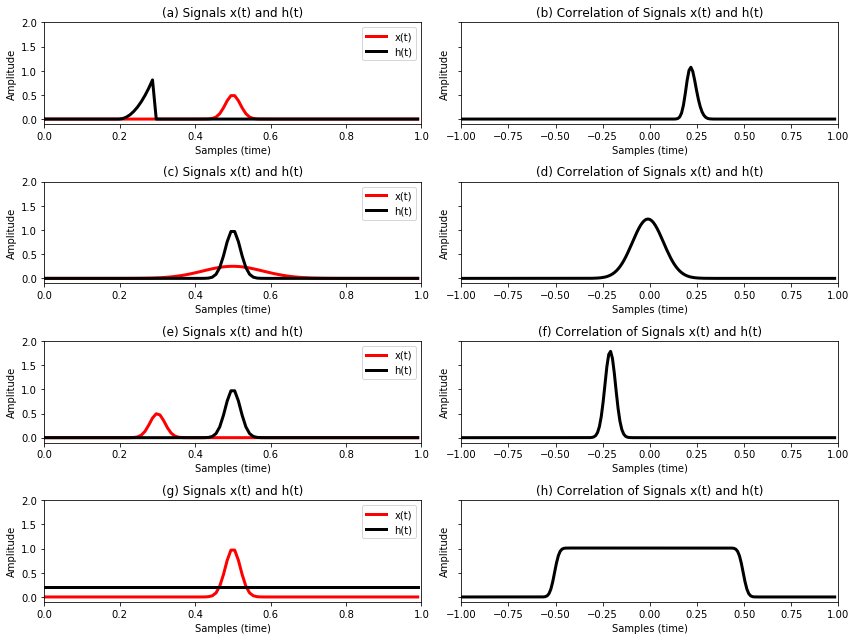

In [10]:
def plotfuncs(t,x,h,n,title):
    plt.subplot(4,2,n)
    plt.plot(t,x,'r',t,h,'k',lw=3)
    plt.xlabel('Samples (time)')
    plt.ylabel('Amplitude')
    plt.title(title+' Signals x(t) and h(t)')
    plt.legend(['x(t)','h(t)'])
    plt.axis([0,1,-0.1,2])

def plotconvo(t,y,n,title):
    ax=plt.subplot(4,2,n)
    plt.plot(t,y,'k',lw=3)
    plt.xlabel('Samples (time)')
    plt.ylabel('Amplitude')
    plt.title(title+' Correlation of Signals x(t) and h(t)')
    plt.axis([-1,1,-0.1,2])
    ax.set_yticklabels([])

# . . Simple convolutional model demonstration
nt=101
t = np.arange(0,1,1/nt)
tauline = np.arange(-1,0.99,1/nt)
xline   = np.arange(0,1,1/nt)

# . . Input signals (shifted in time with respect to each other)
x0 = np.zeros(nt); x0=0.5 *np.exp(-(t-0.5 )**2/(2*0.02**2))
x1 = np.zeros(nt); x1=0.25*np.exp(-(t-0.5 )**2/(2*0.08**2))
x2 = np.zeros(nt); x2=0.5 *np.exp(-(t-0.3 )**2/(2*0.02**2))
x3 = np.zeros(nt); x3=1   *np.exp(-(t-0.5 )**2/(2*0.02**2))

# . . Impulse response (stationary for the four examples)
h0 = np.zeros(nt)
h1 = np.zeros(nt)
h2 = np.zeros(nt)
h3 = np.zeros(nt)
h0 = np.exp(-(t-0.5)**2/(2*0.02**2))
h1 = np.exp(-(t-0.5)**2/(2*0.02**2))
h2 = np.exp(-(t-0.5)**2/(2*0.02**2))
h3 = 0.2+0.*np.exp(-(t-0.5)**2/(2*0.02**2))

#Redo h0
h0=0*h0
h0[20:30]=0.01*np.arange(0,10,1)**2

# . . Plot
plt.figure(figsize=(12, 9))
plotfuncs(xline,x0,h0,1,'(a)')
plotconvo(tauline,np.correlate(x0,h0,mode='full'),2,'(b)')
plotfuncs(xline,x1,h1,3,'(c)')
plotconvo(tauline,np.correlate(x1,h1,mode='full'),4,'(d)')
plotfuncs(xline,x2,h2,5,'(e)')
plotconvo(tauline,np.correlate(x2,h2,mode='full'),6,'(f)')
plotfuncs(xline,x3,h3,7,'(g)')
plotconvo(tauline,np.correlate(x3,h3,mode='full'),8,'(h)')

plt.tight_layout() 
plt.show()

**Figure 13.  Illustration of crosscorrelation of two signals. Left panels: Two signals $x(t)$ and $h(t)$ to be crosscorrelated. Right panels: crosscorrelation result. Note that this operation is not commutative.**

<div class="alert alert-danger">
WARNING: You'll notice that the output of this operation is from -1s to 1s, which is different from the above.  This is because in this case we have used 

    np.correlate(a,b,mode='full')
    
instead of 

    np.correlate(a,b,mode='same')
    
as in the convolution examples above.  If you have arrays $a$ and $b$ of dimension N, then the 'same' option will return an array with dimension N ranging between -N/2 to N/2.  Conversely, the 'full' option will return an array of dimension 2N-1 ranging from -N to N. 

In the above example we have arrays defined between 0-1s. Thus, because we have called the 'full' option, the function has returned the correlation result between ±1s.  This is because the extra delays between the two signals can be up to ±1s.  
</div>

## Crosscorrelation Properties

The correlation integral has the following important properties:

(1) The cross-correlation of $f(t)$ and $g(t)$ is equivalent to the **convolution** of $\overline{f(-t)}$ and $g(t)$.
    
$$f(t)\star g(t) = \overline{f(-t)}\ast g(t) \tag{48} $$

(2) If $f(t)$ is a [Hermitian function](https://en.wikipedia.org/wiki/Hermitian_function) (i.e., has the property of $\overline{f(t)}=f(-t)$) then the following holds:

$$f(t) \star g(t)  = f (t) \ast g(t)\tag{49}$$

(3) If $f(t)$ and $g(t)$ are both Hermitian functions, then 

$$ f(t) \star g(t) = g(t)\star f(t) \tag{50}$$

(4) The cross-correlation of two functions [i.e., $h(t) = f(t) \star g(t)$] satisfies the following in the Fourier domain:

$$ \widehat{H}(\omega) =\mathcal{F}[h(t)] = \mathcal{F}[f(t)\star g(t)] =  \mathcal{F}[\overline{f(-t)}\ast g(t)] = \overline{\widehat{F}(\omega)} \widehat{G}(\omega) \tag{51} $$

## The difference between convolution and correlation

Let's now look at an example showing the difference between the convolution and cross-correlation operations.  In the image below, I have created two signals $x(t)$ and $h(t)$. The second panel shows the **convolution** $y(t) = x(t)\ast h(t)$, while the third panel shows the **convolution**  $y(t) = h(t) \ast x (t)$.  These are identical as should be expected from the communtivity of the convolution operator discussed above.  The fourth panel shows the **correlation** $y_1(t)=x(t)\star h(t)$, while the fifth panel shows the **correlation** $y_2(t)=h(t)\star x(t)$.  You'll notice in this case that $y_2(t)=y_1(-t)$.

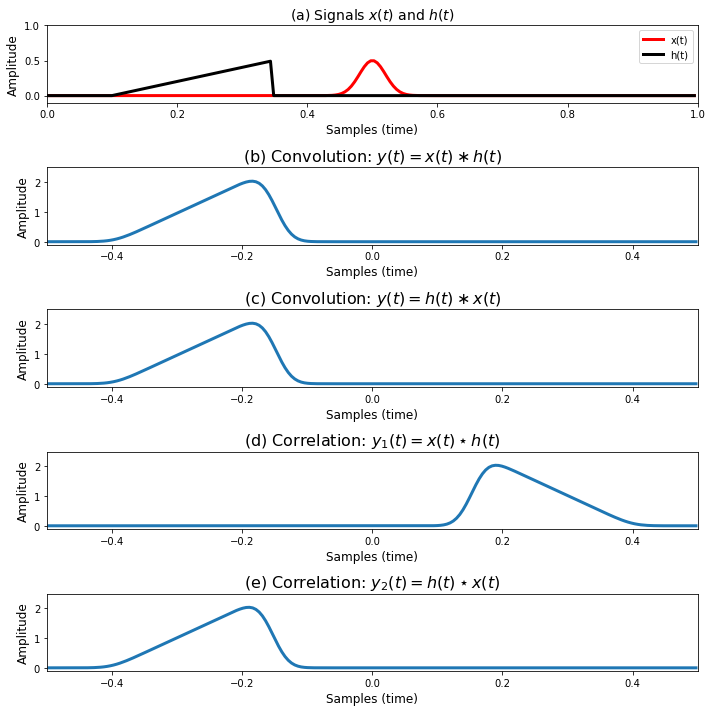

In [8]:
# . . Simple convolutional model demonstration
nt=201
t = np.arange(0,1,1/nt)
tauline = np.arange(-1,0.99,1/nt)
xline   = np.arange(0,1,1/nt)

# . . Input signals (shifted in time with respect to each other)
x = np.zeros(nt)
x=0.5*np.exp(-(t-0.5 )**2/(2*0.02**2))

# . . Input signal 1
h = np.zeros(nt)
h[20:70]=np.arange(0,50,1)/50/2

# . . Plot two signals
plt.figure(figsize=(10, 10))
plt.subplot(5,1,1)
plt.plot(t,x,'r',t,h,'k',lw=3)
plt.xlabel('Samples (time)',size=12)
plt.ylabel('Amplitude',size=12)
plt.title(r'(a) Signals $x(t)$ and $h(t)$',size=14)
plt.legend(['x(t)','h(t)'])
plt.axis([0,1,-0.1,1])

# . . Plot convolution x*h
plt.subplot(5,1,2)
plt.plot(t-max(t)/2,np.convolve(x,h,mode="same"),lw=3)
plt.xlabel('Samples (time)',size=12)
plt.ylabel('Amplitude',size=12)
plt.title(r'(b) Convolution: $y(t)=x(t)\ast h(t)$',size=16)
plt.axis([-0.5,0.5,-0.1,2.5])

# . . Plot convolution h*x
plt.subplot(5,1,3)
plt.plot(t-max(t)/2,np.convolve(h,x,mode="same"),lw=3)
plt.xlabel('Samples (time)',size=12)
plt.ylabel('Amplitude',size=12)
plt.title(r'(c) Convolution: $y(t)=h(t)\ast x(t)$',size=16)
plt.axis([-0.5,0.5,-0.1,2.5])

# . . Plot correlation of h and x
plt.subplot(5,1,4)
plt.plot(t-max(t)/2,np.correlate(x,h,mode="same"),lw=3)
plt.xlabel('Samples (time)',size=12)
plt.ylabel('Amplitude',size=12)
plt.title(r'(d) Correlation: $y_1(t)=x(t)\star h(t)$',size=16)
plt.axis([-0.5,0.5,-0.1,2.5])

# . . Plot correlation of x and h
plt.subplot(5,1,5)
plt.plot(t-max(t)/2,np.correlate(h,x,mode="same"),lw=3)
plt.xlabel('Samples (time)',size=12)
plt.ylabel('Amplitude',size=12)
plt.title(r'(e) Correlation: $y_2(t)=h(t)\star x(t)$',size=16)
plt.axis([-0.5,0.5,-0.1,2.5])

plt.tight_layout() 
plt.show()

**Figure 14. Illustrating the differences between convolution and crosscorrelation. (a) Two signals to be analyzed. (b) Convolution $y(t) = x(t)\ast h(t)$. (c) Convolution $y(t) = h(t)\ast x(t)$, which yields the same result as in (b). (d) Crosscorrelation of $y_1(t) = x(t) \star h(t)$. (d) Crosscorrelation of $y_2(t) = h(t) \star x(t)$, which yields a time-reversed version of (d).**

## Autocorrelation Theorem

The **autocorrelation** of a function $f(t)$, here denoted by $a_f(t) = f(t) \star f(t)$, has the following relationship:

$$ \widehat{A_f}(\omega) = \overline{\widehat{F}(\omega)}\widehat{F}(\omega) = \left|\widehat{F}(\omega)\right|^2. \tag{52} $$

<div class="alert alert-success">
**PROOF:** Let's start with the definition of cross-correlation:

$$
a_f(t) = \int_{-\infty}^{\infty} \overline{f(t^\prime) }\,f(t+t^\prime)\, \mathrm{d}t^\prime \tag{53}
$$

Applying a Fourier Transforms to both sides

$$
\widehat{A_f}(\omega) =  \int_{-\infty}^{\infty}  \int_{-\infty}^{\infty} \overline{f(t^\prime)}\,f(t+t^\prime)\,\mathrm{e}^{-i\omega t} \mathrm{d}t^\prime \mathrm{d}t.  \tag{54}
$$

Let $\tau = t+t^\prime$. Then if $t^\prime$ is held constant, $\mathrm{d}t=\mathrm{d}\tau$, 

$$
\widehat{A_f}(\omega) =  \int_{-\infty}^{\infty}  \int_{-\infty}^{\infty}\overline{f(t^\prime)}\,f(\tau)\,\mathrm{e}^{-i\omega(\tau-t^\prime)} \mathrm{d}t^\prime \mathrm{d}\tau.  \tag{55}
$$

which can be separated 

$$
\widehat{A_f}(\omega) =  
\int_{-\infty}^{\infty}  \overline{f(t^\prime)} \,\mathrm{e}^{i\omega t^\prime}\,\mathrm{d}t^\prime
\cdot
\int_{-\infty}^{\infty} f(\tau)\,\mathrm{e}^{-i\omega \tau} \, \mathrm{d}\tau  \tag{56}
$$

which leads to 

$$ \widehat{A_f}(\omega) = \overline{\widehat{F}(\omega)}\widehat{F}(\omega) = \left|\widehat{F}(\omega)\right|^2.  \tag{57}$$

</div>

Note that **autocorrelation** is the equivalent of computing a function's **power spectrum**.  Let's now look at an autocorrelation example.

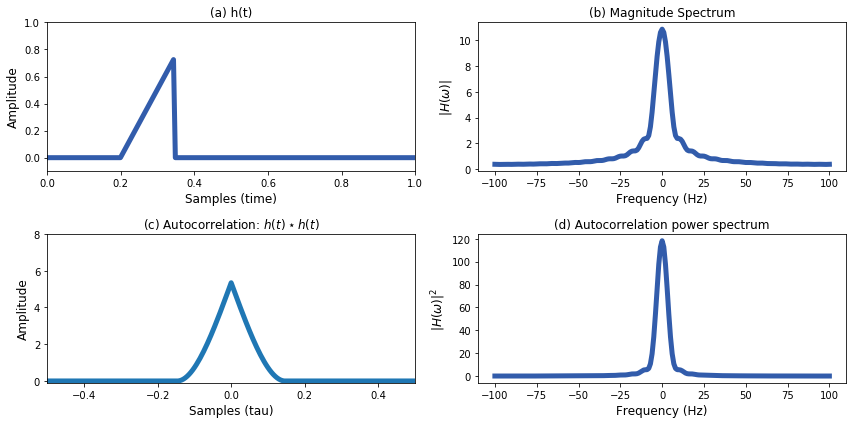

In [12]:
# . . Simple convolutional model demonstration
nt=201
t = np.arange(0,1,1/nt)
tauline = np.arange(-1,0.99,1/nt)
xline   = np.arange(0,1,1/nt)

# . . Input signal 1
h = np.zeros(nt)
h[40:70]=np.arange(0,30,1)/40

# . . F domain
freq1=np.fft.fftshift(np.fft.fftfreq(len(t),1/nt))

# . . Plot two signals
plt.figure(figsize=(12, 6))
plt.subplot(2,2,1)
plt.plot(t,h,"#325cab",lw=5)
plt.xlabel('Samples (time)',size=12)
plt.ylabel('Amplitude',size=12)
plt.title('(a) h(t)')
plt.axis([0,1,-0.1,1])

plt.subplot(2,2,2)
plt.plot(freq1,np.fft.fftshift(np.abs(np.fft.fft(h))),"#325cab",lw=5)
plt.xlabel('Frequency (Hz)',size=12)
plt.ylabel('$|H(\omega)|$',size=12)
plt.title('(b) Magnitude Spectrum')
#plt.axis([0,1,-0.1,1])

# . . Plot correlation of x and h
plt.subplot(2,2,3)
plt.plot(t-max(t)/2,np.correlate(h,h,mode="same"),lw=5)
plt.xlabel('Samples (tau)',size=12)
plt.ylabel('Amplitude',size=12)
plt.title('(c) Autocorrelation: $h(t)\star h(t)$')
plt.axis([-0.5,0.5,-0.1,8])

plt.subplot(2,2,4)
plt.plot(freq1,np.fft.fftshift(np.abs(np.fft.fft(np.correlate(h,h,mode="same")))),"#325cab",lw=5)
plt.xlabel('Frequency (Hz)',size=12)
plt.ylabel('$|H(\omega)|^2$',size=12)
plt.title('(d) Autocorrelation power spectrum')
#plt.axis([0,1,-0.1,1])

plt.tight_layout() 
plt.show()

**Figure 15. Illustration of the autocorrelation theorem.  (a) Input signal $h(t)$. (b) Fourier magnitude spectrum of (a).  (c) Autocorrelation of $h(t)\star h(t)$. (d) Autocorrelation powe spectrum $|H(\omega)|^2$ of (c).**

# Deconvolution (and Polynomial multiplication/division)

I was also interested in the abilities of Scipy in performing deconvolution.  Recall that if $y(t) = x(t)\ast h(t)$ that this operation performs the equivalent of

$$x(t) = \mathcal{F}^{-1}\left[\frac{\widehat{Y}(\omega)}{\widehat{H}(\omega)}\right]. \tag{58}$$

However, it does not compute it directly from the Fourier spectra.  Rather, it aims to find a **polynomial expression** that adequately approximates $h(t)$ and then effectively uses polynomial division to remove this influence of $h(t)$ from $y(t)$.  

This is somewhat analogous polynomial multiplication and division that you may have done in earlier courses. For example, if $x(t)=t^2+1$ and $h(t)=2t+7$, then $y(t)=x(t)\ast h(t)$ is the **convolution of these two polynomials**.  Let these vectors represent the polynomial coefficients: $u=[1,0,1]$ and $v=[2,7]$.  The resulting **discrete convolution** of $u$ and $v$ is $[2,7,2,7]$ or 

$$y(t) = 2t^3+7t^2+2t+7, \tag{59}$$

which is equivalent to **polynomial multiplication** of the two functions $x(t)$ and $h(t)$. Let's verify this numerically:

In [4]:
u=[1,0,1]
v=[2,7]
aa=np.convolve(u,v,mode="full")
print("u:",u)
print("v:",v)
print("The convolution of u and v is:",aa)

u: [1, 0, 1]
v: [2, 7]
The convolution of u and v is: [2 7 2 7]


The **deconvolution** of $h(t)$ from $y(t)$ is then equivalent to **polynomial division**:

$$x(t) = \frac{2t^3+7t^2+2t+7}{2t+7} = \frac{(t^2+1)(2t+7)}{2t+7} = t^2+1. \tag{60}$$

This approach works great if you can find a **stable** polynomial approximation for $h(t)$.  

In [14]:
recovered,remainder = scipy.signal.deconvolve(aa,u)
print("The deconvolution of aa by u is:",recovered)
print("The remainder is:",remainder)

The deconvolution of aa by u is: [ 2.  7.]
The remainder is: [ 0.  0.  0.  0.]


This doesn't always exist ... and we'll have to dig a bit deeper in a few weeks when discussing Z-transforms to figure out why. However, if we modify the above expression by changing the 7 into a 6 such that you can no longer factor out $2t+7$

$$x(t) = \frac{2t^3+7t^2+2t+6}{2t+7}. \tag{61}$$

In [15]:
aanew = [2,7,2,6]
recovered,remainder = scipy.signal.deconvolve(aanew,u)
print("The deconvolution of aanew by u is:",recovered)
print("The remainder is:",remainder)

The deconvolution of aanew by u is: [ 2.  7.]
The remainder is: [ 0.  0.  0. -1.]


Let's explore an example where convolution and then deconvolution is being applied using the following two function calls:

* *y = np.convolve(x,h,mode='same')* 
* *x,remainder=scipy.signal.deconvolve(y,h)*

In [5]:
# . . Define plot functions
def plot_time_domain(tline,f,plotcol,title=""):
    plt.plot(tline,f, color=plotcol, label="original",lw=5) 
    plt.xlabel('Time (s)',fontsize=16)
    plt.ylabel('Amplitude',fontsize=16)
    plt.title(title,fontsize=16)
    plt.axis([np.min(tline),np.max(tline),-0.2*np.max(f),1.1*np.max(f)])   
    
def plot_freq_domain(fline,F,plotcol,title):
    plt.plot(fline,F, color=plotcol, label="original",lw=5) 
    plt.xlabel('Frequency (Hz)',fontsize=16)
    plt.ylabel('Amplitude',fontsize=16)
    plt.title(title,fontsize=16)
    plt.axis([np.min(fline),np.max(fline),-0.2*np.max(F),1.1*np.max(F)])

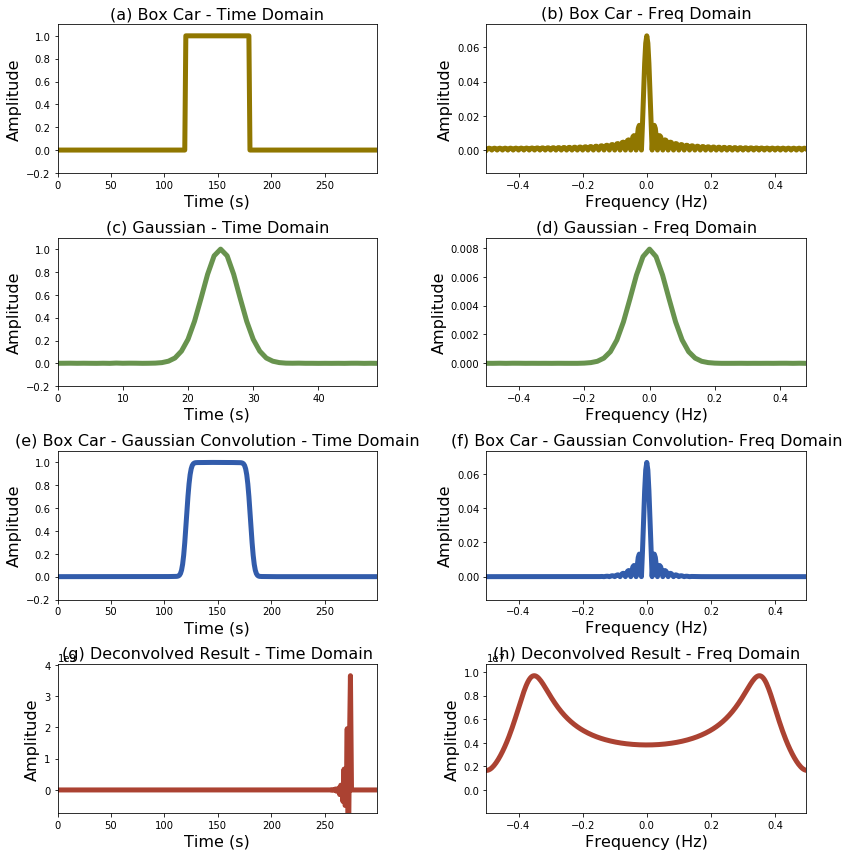

In [8]:
nt=300
random_noise_level=0.001 # . . For Gaussian filter
DC_term = 0.00#0.01 # . . For Gaussian Filter

# . . Time and Frequency Line
tline1 = np.arange(0,nt  ,1)
tline2 = np.arange(0,nt/6,1)
           
# . . Let the signal be box-like
signal = np.repeat([0., 0., 1., 0., 0.], nt/5)
fline1 =   np.arange(-len(signal)/2, len(signal)/2, 1)/nt
fline2 = 6*np.arange(-len(signal)/12,len(signal)/12,1)/nt

# . . Use a gaussian filter
gauss = np.exp(-( (tline2-25.)/4)**2 ) +random_noise_level*np.abs(np.random.randn(int(nt/6)))+DC_term

# . . Calculate the convolution and normalize
filtered = np.convolve(signal, gauss, mode='same') / np.sum(gauss)

# . . Now let's call the deconvolution script!
deconv, devisor = scipy.signal.deconvolve( filtered, gauss )

#the deconvolution has n = len(signal) - len(gauss) + 1 points
n = len(signal)-len(gauss)+1

# so we need to expand it by 
s = int((len(signal)-n)/2)

#on both sides.
deconv_res = np.zeros(len(signal))
deconv_res[s:len(signal)-s-1] = deconv
deconv =  deconv_res*np.sum(gauss)

#### Plot #### 
plt.figure(figsize=(12, 12))

plt.subplot(4,2,1)
plot_time_domain(tline1,signal,"#907700",title="(a) Box Car - Time Domain")

plt.subplot(4,2,2)
plot_freq_domain(fline1,np.fft.fftshift(np.abs(np.fft.fft(signal)))/(3*nt),"#907700",title="(b) Box Car - Freq Domain")

plt.subplot(4,2,3)
plot_time_domain(tline2,gauss,"#68934e",title="(c) Gaussian - Time Domain")

plt.subplot(4,2,4)
plot_freq_domain(fline2,np.fft.fftshift(np.abs(np.fft.fft(gauss)))/(3*nt),"#68934e",title="(d) Gaussian - Freq Domain")

plt.subplot(4,2,5)
plot_time_domain(tline1,filtered,"#325cab",title="(e) Box Car - Gaussian Convolution - Time Domain")

plt.subplot(4,2,6)
plot_freq_domain(fline1,np.fft.fftshift(np.abs(np.fft.fft(filtered)))/(3*nt),"#325cab",title="(f) Box Car - Gaussian Convolution- Freq Domain")

plt.subplot(4,2,7)
plot_time_domain(tline1,deconv,"#ab4232",title="(g) Deconvolved Result - Time Domain")

plt.subplot(4,2,8)
plot_freq_domain(fline1,np.fft.fftshift(np.abs(np.fft.fft(deconv)))/(3*nt),"#ab4232",title="(h) Deconvolved Result - Freq Domain")

plt.tight_layout() 
plt.show()       

**Figure 16. Illustration of the deconvolution process involving both time- (left panels) and frequency (right panels).  (a) Original box car function and (b) associated Fourier magnitude spectrum.  (c) Gaussian function and (d) the associated Fourier magnitude spectrum.  (e) Convolution of box car in (a) and Gaussian in (c) along with (f) the Fourier magnitude spectrum of the convolved result. (g) The result of deconvolving the Gaussian in (c) from the convolved result in (e) along with (h) the associated deconvolved spectrum.**

Overall, this process seems to have done a fairly stable result.  However, if you play around with the parameters and, e.g., set *DC_term*=0 in the code section above, you'll see that things become unstable mighty quickly!

## Deconvolution in practice

So far "decon" is an interesting theoretical operation ... but does it actually matter in practice? The answer is a resounding yes! Because we are using seismic waves to interrogate the Earth to learn more about its structure, it's very important that we attempt to remove as much of the wavelet effect as possible (which broadens the response and reduces the bandwidth (or difference between minimum and maximum amplitudes).  Let's look at two examples:

<img src="Fig/DECON1.jpg" width="800">

**Figure 17. 2D seismic section showing the benefits of applying 2D deconvolution to land data. (a) Seismic image without applying deconvolution.  (b) Same image as in (a) but after applying deconvolution.  Note the improvement in resolution! (Credit: Cary, CSEG Recorder)**

<img src="Fig/DECON2.jpg" width="800">

**Figure 18. 2D seismic section showing the benefits of applying 2D deconvolution to marine data. (a) Seismic image without applying deconvolution.  (b) Same image as in (a) but after applying deconvolution.  Again, note the improvement in resolution! (Credit: Schlumberger)**


## References

1. Bracewell, R.N., 1965, The Fourier Transform and Applications, McGraw-Hill, New York.
2. James, J.F. 2011, A Student's Guide to Fourier Transforms, 3rd ed, Cambridge University Press.
